In [41]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# import from pythin packages
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import cmocean
from datetime import datetime, date, timedelta

# import from pre-built data classes
from data_handler import *
from steric_height import StericHeight
from plotting_fns import PlottingFns
from region import Region
from utils import Utils as utls

pfns = PlottingFns()

In [3]:
lwe = GRACE(from_file=False).ds.lwe_thickness
#lwef = GRACE().ds.lwe_thickness

In [4]:
# load dynamic ocean topography data from class
dot = DOT().ds.dot
msl = ERA5().ds.msl

# set up stweric height
sha = StericHeight(ssh_ref='DOT',
                   ssh=dot,
                   lwe=lwe,
                   msl=msl,
                  ).get_sha(startend=[dot.time[0],dot.time[-1]])#[pd.Timestamp(2002,7,1),pd.Timestamp(2017,6,1)])

# set up stweric height
# shaf = StericHeight(ssh_ref='DOT',
#                    ssh=dot,
#                    lwe=lwef,
#                    msl=msl,
#                   ).get_sha(startend=[dot.time[0],dot.time[-1]])

In [5]:
soi_fname = '../data/SOI/soi_noaa.csv'
data = pd.read_csv(soi_fname,header=None,usecols=[1,2,3,4,5,6,7,8,9,10,11,12]).to_numpy()
years = np.repeat(pd.read_csv(soi_fname,header=None,usecols=[0]).to_numpy(),12)
months = np.tile(np.arange(1,13),len(data))
time = [pd.Timestamp(y,m,1) for y,m in zip (years,months)]
data = data.reshape(np.size(data))
soi = xr.DataArray(data,coords={'time': time})


In [6]:
#sha_data = sha.sha
#sha_data = sha.sha.groupby('time.month') - sha.sha.groupby('time.month').mean()
soi = soi.sel(time=slice(sha.time[0],sha.time[-1]))


In [7]:
def composite_analysis(idx_data,sha_data,limit,idx_name,label,title_text=None,vmax=3,lower_limit=None,background_data=None,background_label=None,leg_loc='upper right'):

    if lower_limit is None:
        lower_limit = -limit
        lower_fill_text = '-' + (title_text or str(limit))
    else:
        lower_fill_text = str(lower_limit)

    fill_text = title_text or str(limit)

    idx_positive = idx_data >= limit
    idx_negative = idx_data <= lower_limit

    #spb = sha_data.sel(latitude=slice(-60,-50),longitude=slice(-130,-110)).mean(['latitude','longitude'])

    fig = plt.figure(figsize=(12,8))

    gs = fig.add_gridspec(2,2,height_ratios=[1,2])
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0],projection=ccrs.SouthPolarStereo())
    ax3 = fig.add_subplot(gs[1, 1],projection=ccrs.SouthPolarStereo())

    ax=ax1
    if background_data is not None:
        ax.plot(background_data.time,background_data,color='#96ae8d',label=background_label)
    ax.plot(idx_data.time,idx_data,color='olive',label=label)
    ax.plot(idx_data.time,np.zeros_like(idx_data),color='#373e02')
    #ax.twinx().plot(spb.time,spb,color='g')
    ax.fill_between(idx_data.time, 0,5, where=idx_positive, alpha=0.4, facecolor='darkkhaki',label='+/- '+fill_text)
    ax.fill_between(idx_data.time,-5,0, where=idx_negative, alpha=0.4, facecolor='darkkhaki')
    ax.set_ylim([-5,5])
    ax.set_ylabel(idx_name)
    ax.legend(loc=leg_loc)
    ax.set_title('(a)',loc='left')
    ax.grid()

    sha_pos = sha_data.where(idx_positive,drop=True).mean('time')
    sha_neg = sha_data.where(idx_negative,drop=True).mean('time')
    #fig, axs = plt.subplots(1,2,figsize=(12,4),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    axs=[ax2,ax3]
    pfns.sp(axs[0],sha_pos,cmap=cmocean.cm.balance,cbar='SHA (cm)',vmax=vmax,cbar_orientation='vertical',land_zorder=3)#title='POSITIVE ' + idx_name + ', (> ' + fill_text + ')')
    pfns.sp(axs[1],sha_neg,cmap=cmocean.cm.balance,cbar='SHA (cm)',vmax=vmax,cbar_orientation='vertical',land_zorder=3)#title='NEGATIVE ' + idx_name + ', (< '+ lower_fill_text + ')'
    ax2.set_title('(b)',loc='left')
    ax3.set_title('(c)',loc='left')
    ax2.text(40,-80,'+'+idx_name,transform=ccrs.PlateCarree(),size=15,c='#373e02',ha='center',bbox=dict(boxstyle="square",facecolor='darkkhaki',alpha=0.5))
    ax3.text(40,-80,'-'+idx_name,transform=ccrs.PlateCarree(),size=15,c='#373e02',ha='center',bbox=dict(boxstyle="square",facecolor='darkkhaki',alpha=0.5))


    fig.tight_layout()

    return fig




In [8]:
#composite_analysis(soi,sha.sha,soi.std(),'SOI (UNFILTERED)',r'$1\sigma$')

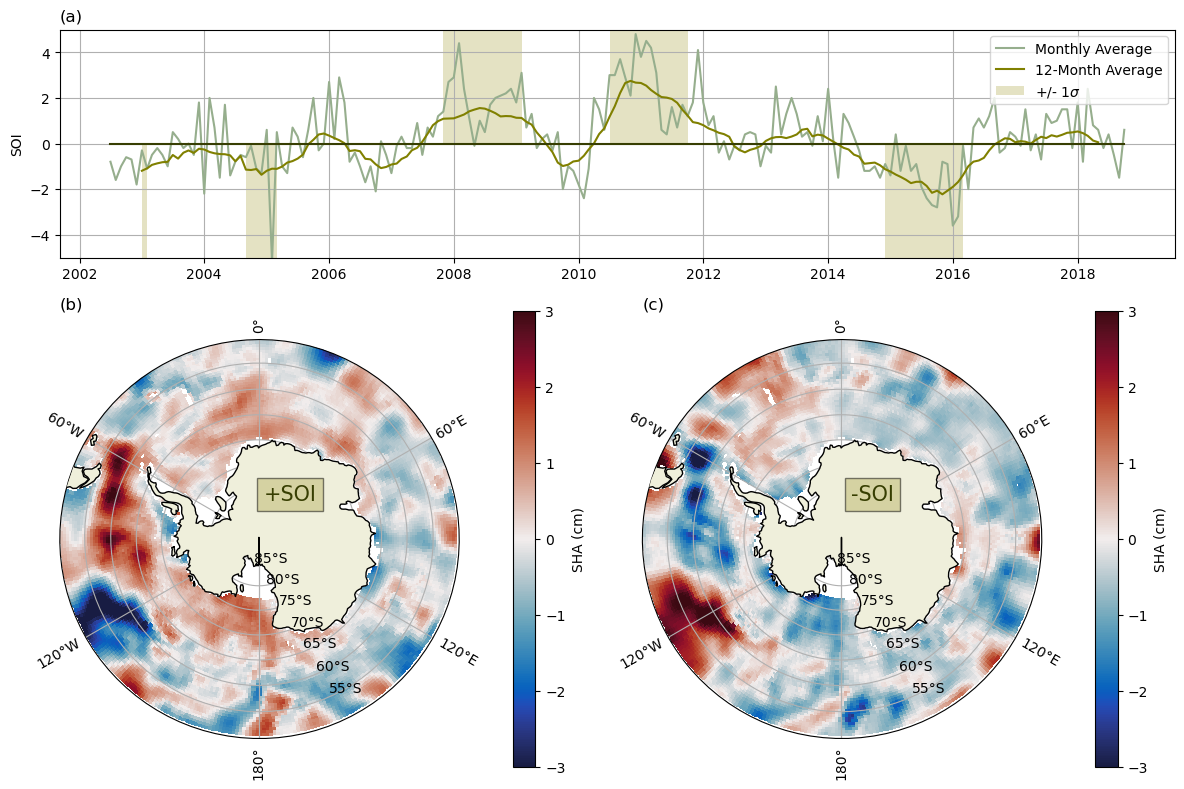

In [9]:
soi_roll = soi.rolling(time=12,center=True).mean('time')
soi_roll_mean = soi_roll.mean()
soi_roll_adjusted = soi_roll - soi_roll_mean
soi_fig = composite_analysis(soi_roll_adjusted,
                   sha.sha.rolling(time=12,center=True).mean('time'),
                   soi_roll_adjusted.std().item(),
                   'SOI',
                   '12-Month Average',
                   r'$1\sigma$',
                   background_data=soi,
                   background_label='Monthly Average')
#soi_fig.savefig('plots/figure6.png',dpi=200,transparent=True,bbox_inches='tight')


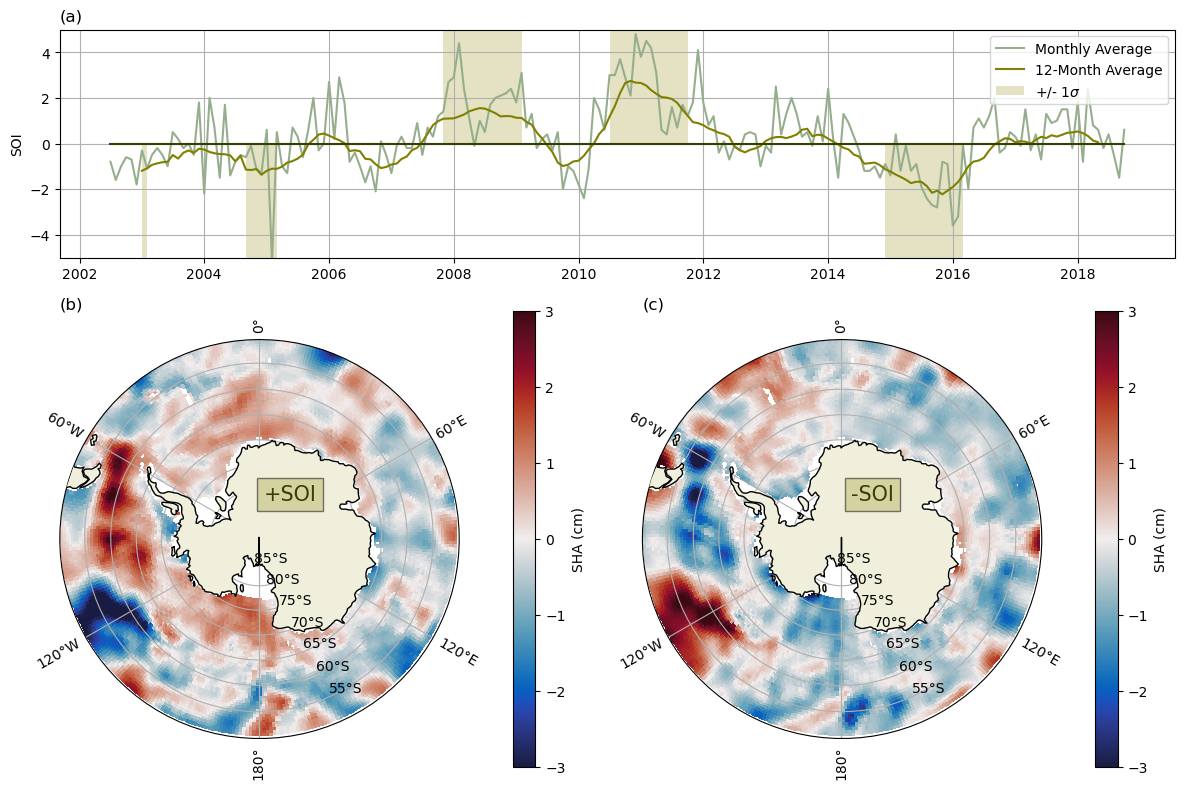

In [10]:
soi_roll = soi.rolling(time=12,center=True).mean('time')
soi_roll_mean = soi_roll.mean()
soi_roll_adjusted = soi_roll - soi_roll_mean
sha_cmt = sha.sha.groupby('time.month') - sha.sha.groupby('time.month').mean()
soi_fig = composite_analysis(soi_roll_adjusted,
                   sha_cmt.rolling(time=12,center=True).mean('time'),
                   soi_roll_adjusted.std().item(),
                   'SOI',
                   '12-Month Average',
                   r'$1\sigma$',
                   background_data=soi,
                   background_label='Monthly Average')

In [11]:
sam=Index('SAM').da
sam = sam.sel(time=slice(sha.time[0],sha.time[-1]))

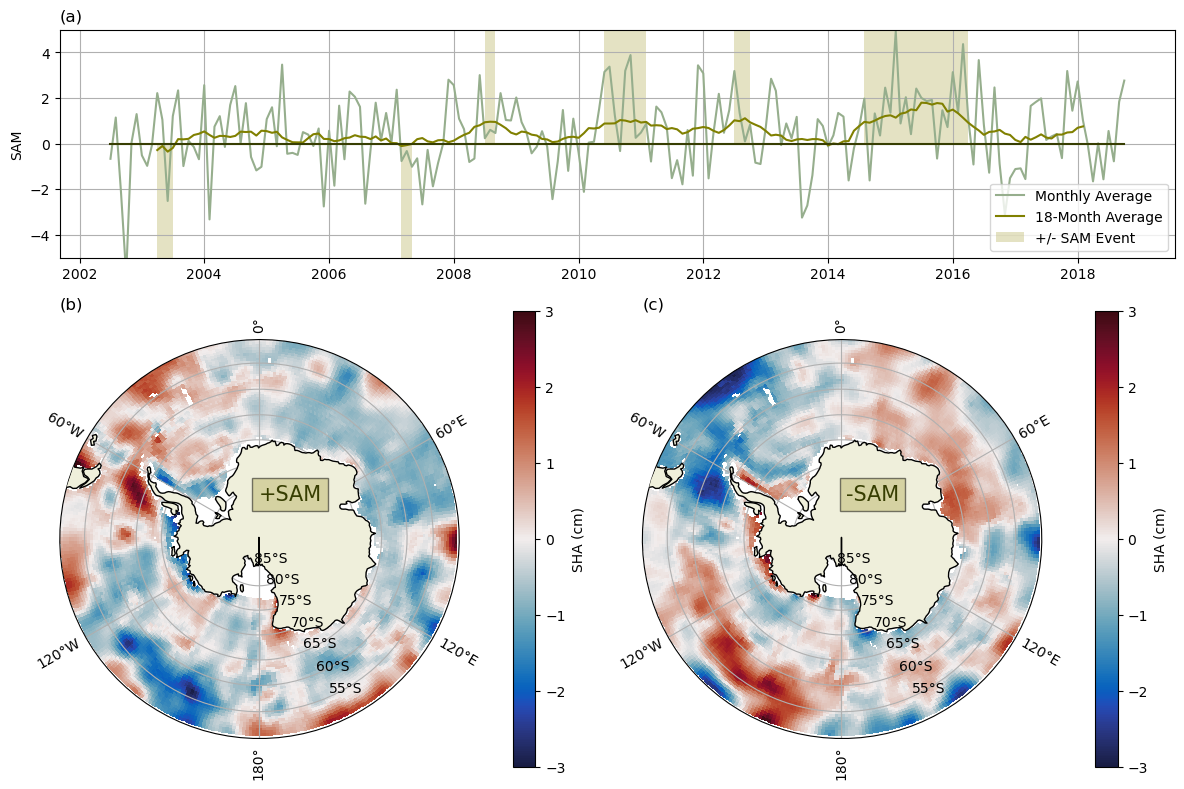

In [12]:
sam_fig=composite_analysis(sam.rolling(time=18,center=True).mean('time'),
                   sha.sha.rolling(time=18,center=True).mean('time'),
                   sam.rolling(time=18,center=True).mean('time').std() * 2,
                   'SAM',
                   '18-Month Average',
                   'SAM Event',#r'$2\sigma$',
                   lower_limit = 0,
                   background_data=sam,
                   background_label='Monthly Average',
                   leg_loc = 'lower right')
sam_fig.savefig('plots/figure7.png',dpi=200,transparent=True,bbox_inches='tight')


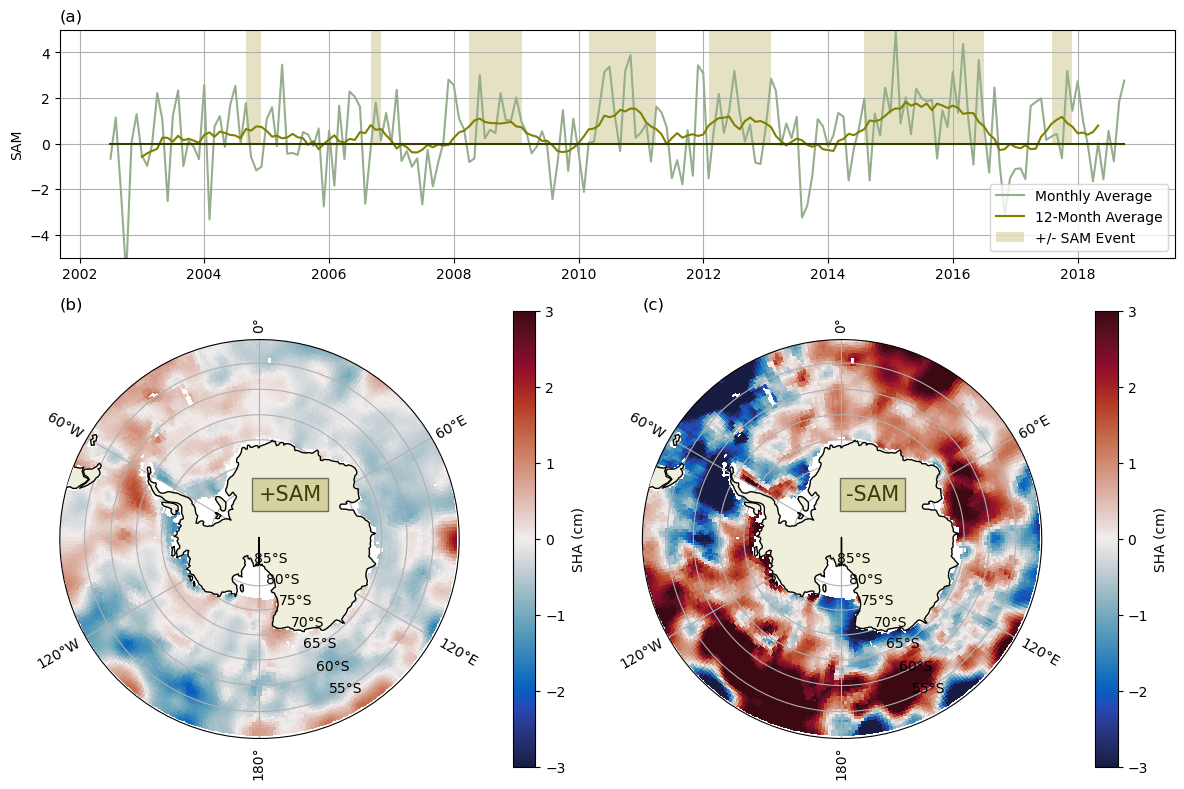

In [23]:
sam_fig=composite_analysis(sam.rolling(time=12,center=True).mean('time'),
                   sha.sha.rolling(time=12,center=True).mean('time'),
                   sam.rolling(time=12,center=True).mean('time').std(),
                   'SAM',
                   '12-Month Average',
                   'SAM Event',#r'$2\sigma$',
                   #lower_limit = 0,
                   background_data=sam,
                   background_label='Monthly Average',
                   leg_loc = 'lower right')
sam_fig.savefig('plots/figure7.png',dpi=200,transparent=True,bbox_inches='tight')


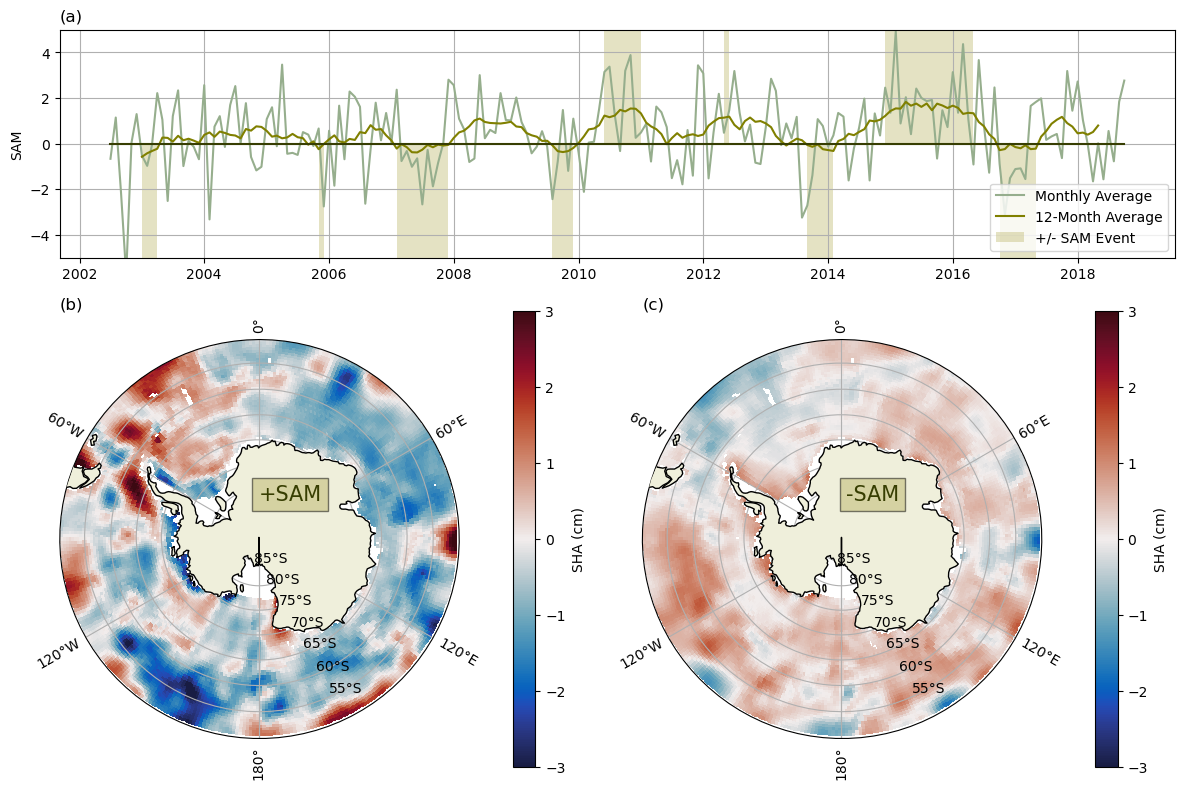

In [27]:
# TEST IMPACT OF REMOVING TREND
roll_window = 12
sam_fig=composite_analysis(sam.rolling(time=roll_window,center=True).mean('time'),
                   sha.sha.rolling(time=roll_window,center=True).mean('time'),
                   sam.rolling(time=roll_window,center=True).mean('time').std()*2,
                   'SAM',
                   str(roll_window)+'-Month Average',
                   'SAM Event',#r'$2\sigma$',
                   lower_limit = 0,
                   background_data=sam,
                   background_label='Monthly Average',
                   leg_loc = 'lower right')


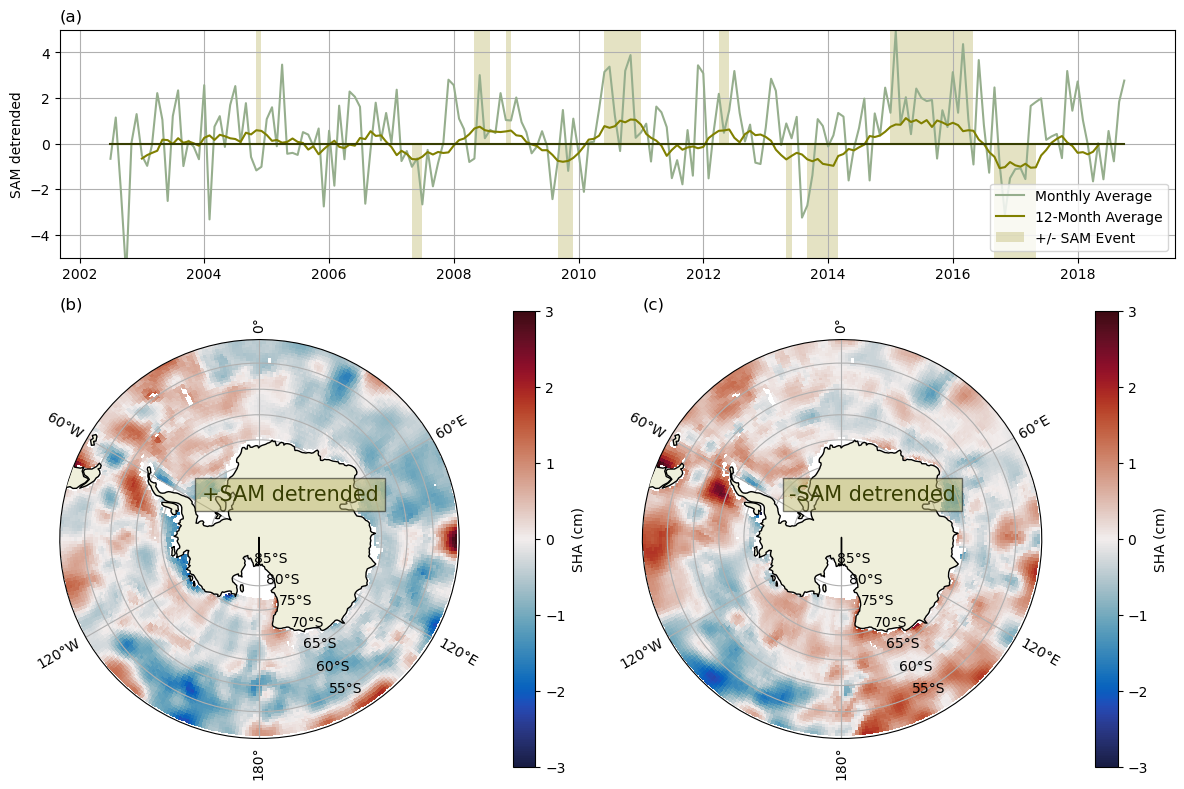

In [15]:
# TEST IMPACT OF REMOVING TREND
sam_detrended = utls.detrend_dim(sam,'time')
roll_window = 12
sam_fig=composite_analysis(sam_detrended.rolling(time=roll_window,center=True).mean('time'),
                   sha.sha.rolling(time=roll_window,center=True).mean('time'),
                   sam_detrended.rolling(time=roll_window,center=True).mean('time').std(),
                   'SAM detrended',
                   str(roll_window)+'-Month Average',
                   'SAM Event',#r'$2\sigma$',
                   #lower_limit = 0,
                   background_data=sam,
                   background_label='Monthly Average',
                   leg_loc = 'lower right')


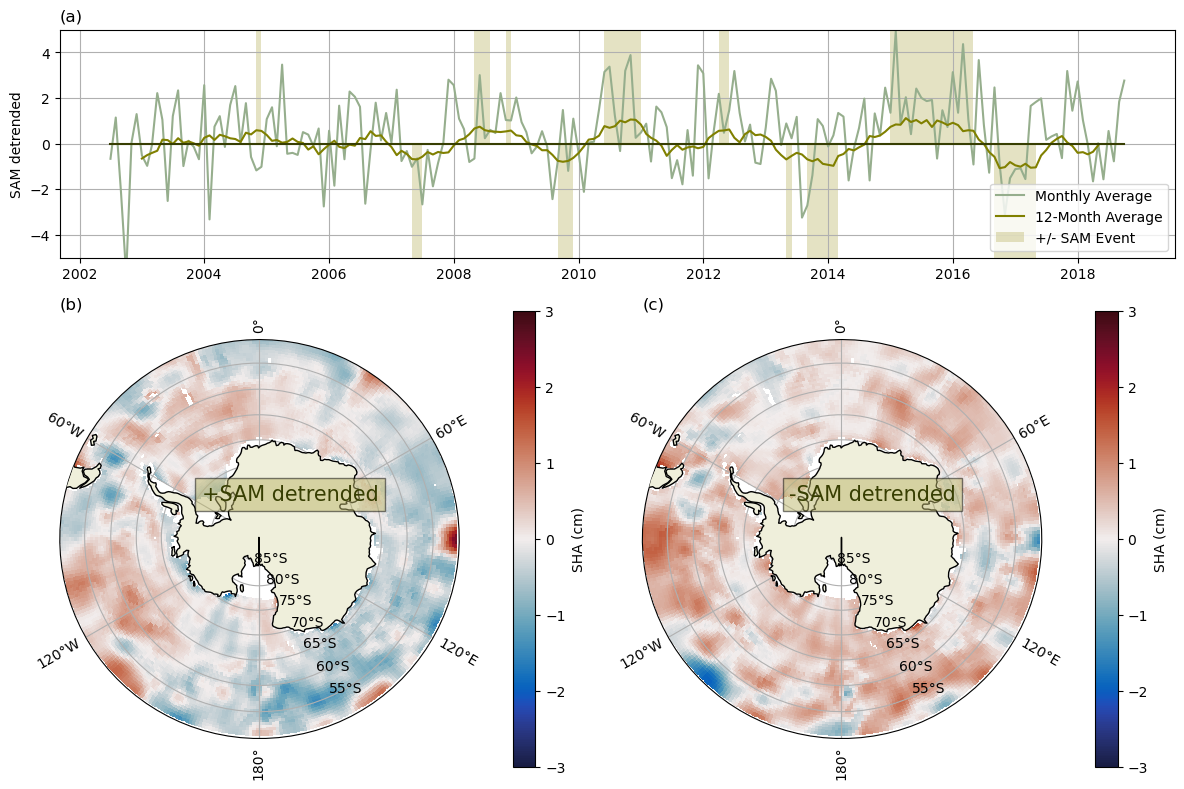

In [16]:
# TEST IMPACT OF REMOVING TREND
sam_detrended = utls.detrend_dim(sam,'time')
sha_detrended = utls.detrend_dim(sha.sha,'time')
roll_window = 12
sam_fig=composite_analysis(sam_detrended.rolling(time=roll_window,center=True).mean('time'),
                   sha_detrended.rolling(time=roll_window,center=True).mean('time'),
                   sam_detrended.rolling(time=roll_window,center=True).mean('time').std(),
                   'SAM detrended',
                   str(roll_window)+'-Month Average',
                   'SAM Event',#r'$2\sigma$',
                   #lower_limit = 0,
                   background_data=sam,
                   background_label='Monthly Average',
                   leg_loc = 'lower right')


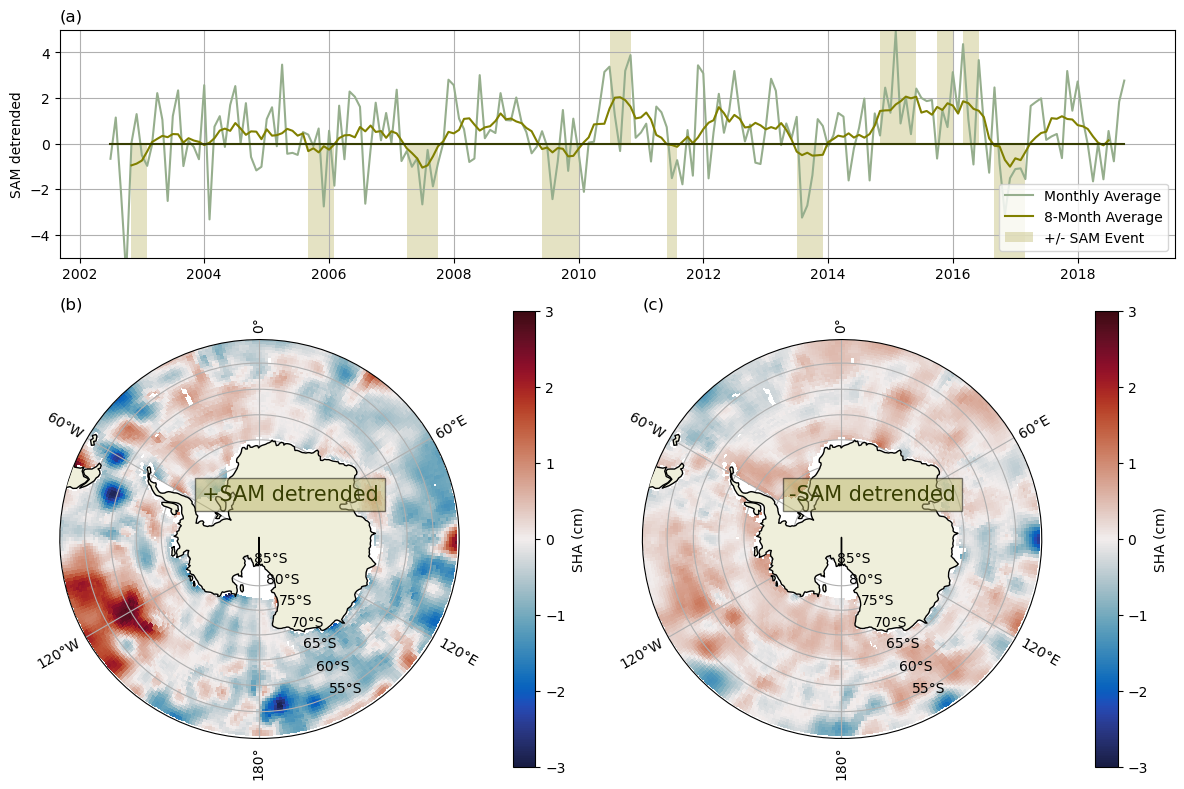

In [17]:
# TEST IMPACT OF REMOVING TREND
roll_window = 8
sam_fig=composite_analysis(sam.rolling(time=roll_window,center=True).mean('time'),
                   sha_detrended.rolling(time=roll_window,center=True).mean('time'),
                   sam.rolling(time=roll_window,center=True).mean('time').std()*2,
                   'SAM detrended',
                   str(roll_window)+'-Month Average',
                   'SAM Event',#r'$2\sigma$',
                   lower_limit = 0,
                   background_data=sam,
                   background_label='Monthly Average',
                   leg_loc = 'lower right')


In [44]:
# SINGLE ONLY
def composite_analysis_single(idx_data,sha_data,limit,idx_name,label,title_text=None,vmax=3,lower_limit=0,background_data=None,background_label=None,leg_loc='upper right'):

    if lower_limit is None:
        lower_limit = -limit
        lower_fill_text = '-' + (title_text or str(limit))
    else:
        lower_fill_text = str(lower_limit)

    fill_text = title_text or str(limit)

    idx_positive = idx_data >= limit
    idx_negative = idx_data <= lower_limit

    #spb = sha_data.sel(latitude=slice(-60,-50),longitude=slice(-130,-110)).mean(['latitude','longitude'])

    fig = plt.figure(figsize=(10,10))

    gs = fig.add_gridspec(2,3,height_ratios=[1,3],width_ratios=[1,5,1])
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 1],projection=ccrs.SouthPolarStereo())

    ax=ax1
    if background_data is not None:
        ax.plot(background_data.time,background_data,color='#96ae8d',label=background_label)
    ax.plot(idx_data.time,idx_data,color='olive',label=label)
    ax.plot(idx_data.time,np.zeros_like(idx_data),color='#373e02')
    #ax.twinx().plot(spb.time,spb,color='g')
    ax.fill_between(idx_data.time, 0,5, where=idx_positive, alpha=0.4, facecolor='darkkhaki',label='+/- '+fill_text)
    ax.fill_between(idx_data.time,-5,0, where=idx_negative, alpha=0.4, facecolor='darkkhaki')
    ax.set_ylim([-5,5])
    ax.set_ylabel(idx_name)
    ax.legend(loc=leg_loc)
    ax.set_title('(a)',loc='left')
    ax.grid()

    sha_pos = sha_data.where(idx_positive,drop=True).mean('time')
    im = pfns.sp(ax2,sha_pos,cmap=cmocean.cm.balance,cbar='SHA (cm)',vmax=vmax,cbar_orientation='vertical',land_zorder=3)#title='POSITIVE ' + idx_name + ', (> ' + fill_text + ')')
    ax2.set_title('(b)',loc='left')
    ax2.text(40,-80,'+'+idx_name,transform=ccrs.PlateCarree(),size=15,c='#373e02',ha='center',bbox=dict(boxstyle="square",facecolor='darkkhaki',alpha=0.5))

    fig.tight_layout()

    return fig




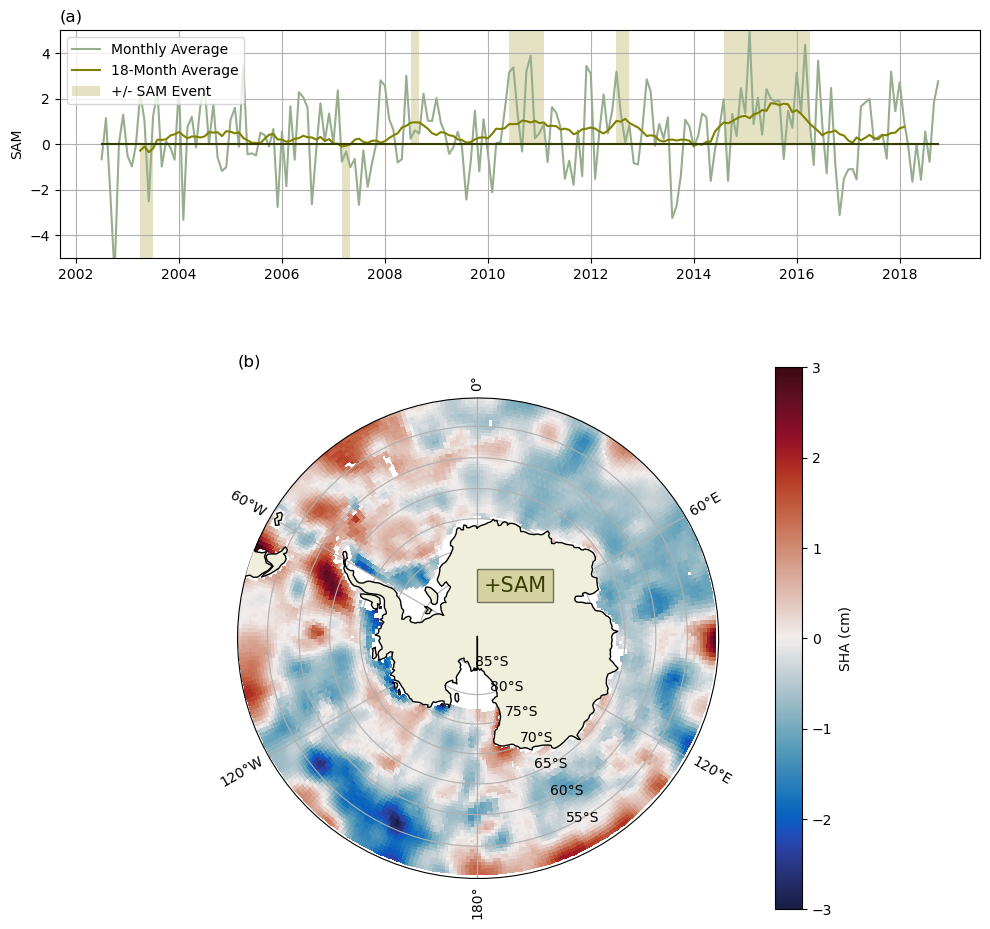

In [54]:
roll_window = 18
pfns = PlottingFns()
sam_fig=composite_analysis_single(sam.rolling(time=roll_window,center=True).mean('time'),
                   sha.sha.rolling(time=roll_window,center=True).mean('time'),
                   sam.rolling(time=roll_window,center=True).mean('time').std() * 2,
                   'SAM',
                   str(roll_window)+'-Month Average',
                   'SAM Event',#r'$2\sigma$',
                   #lower_limit = 0,
                   background_data=sam,
                   background_label='Monthly Average',
                   leg_loc = 'upper left')
sam_fig.savefig('plots/figure7_single.png',dpi=200,transparent=True,bbox_inches='tight')


In [ ]:
# TEST IMPACT OF REMOVING SEASONAL CYCLE
idx = soi_roll_adjusted <= -soi_roll_adjusted.std().item()

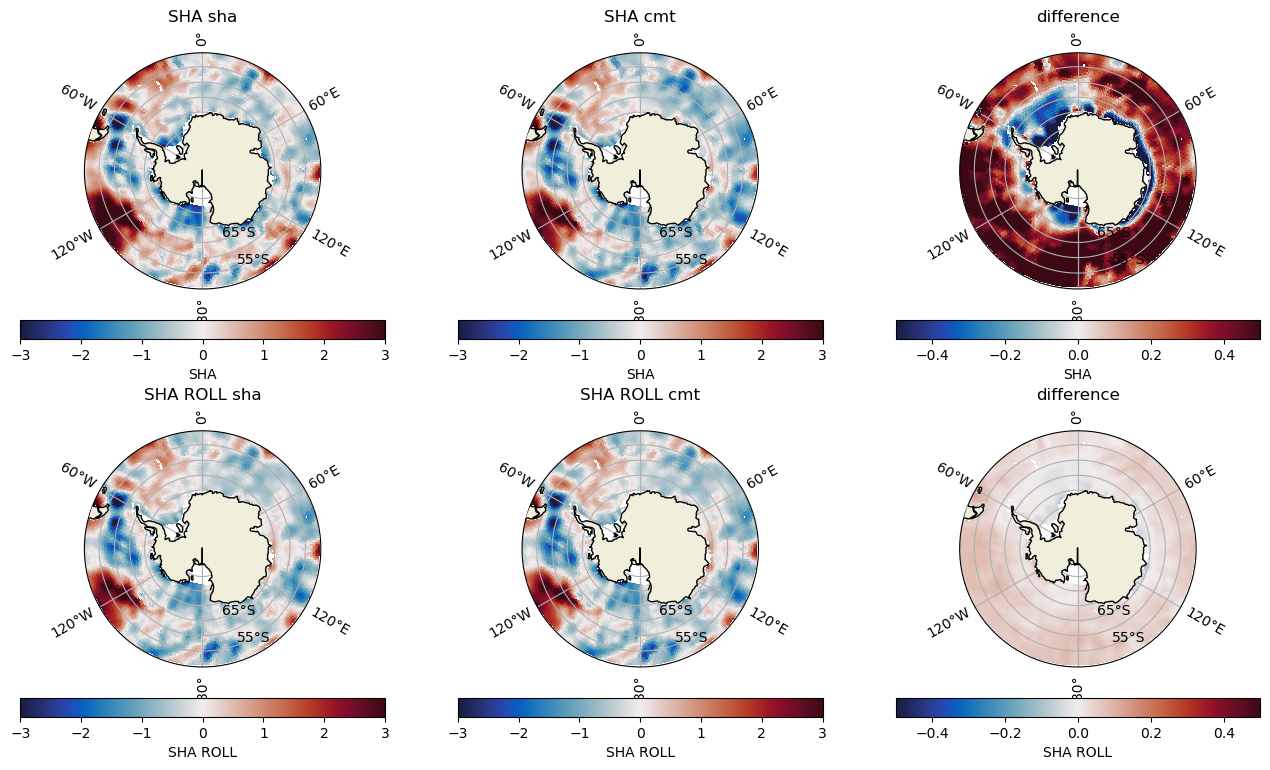

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,5),subplot_kw={'projection':ccrs.SouthPolarStereo()})

def plot_row(r,df,du,lbl):
    gf_neg = df.where(idx==True,drop=True)
    gu_neg = du.where(idx==True,drop=True)
    pfns.sp(ax[r][0],gf_neg.mean('time'),title=lbl+' sha',vmax=3,cmap=cmocean.cm.balance,cbar=lbl)
    pfns.sp(ax[r][1],gu_neg.mean('time'),title='SHA - cmt',vmax=3, cmap = cmocean.cm.balance,cbar=lbl)
    pfns.sp(ax[r][2],gf_neg.mean('time') - gu_neg.mean('time'),title='difference',vmax=0.5,cmap=cmocean.cm.balance,cbar=lbl)

#plot_row(0,sha.sha,sha_cmt,'SHA')
#plot_row(1,shaf.sha,sha.sha,'SHA')
plot_row(1,sha.sha.rolling(time=12,center=True).mean('time'),sha_cmt.rolling(time=12,center=True).mean('time'),'SHA smoothed (12-month)')

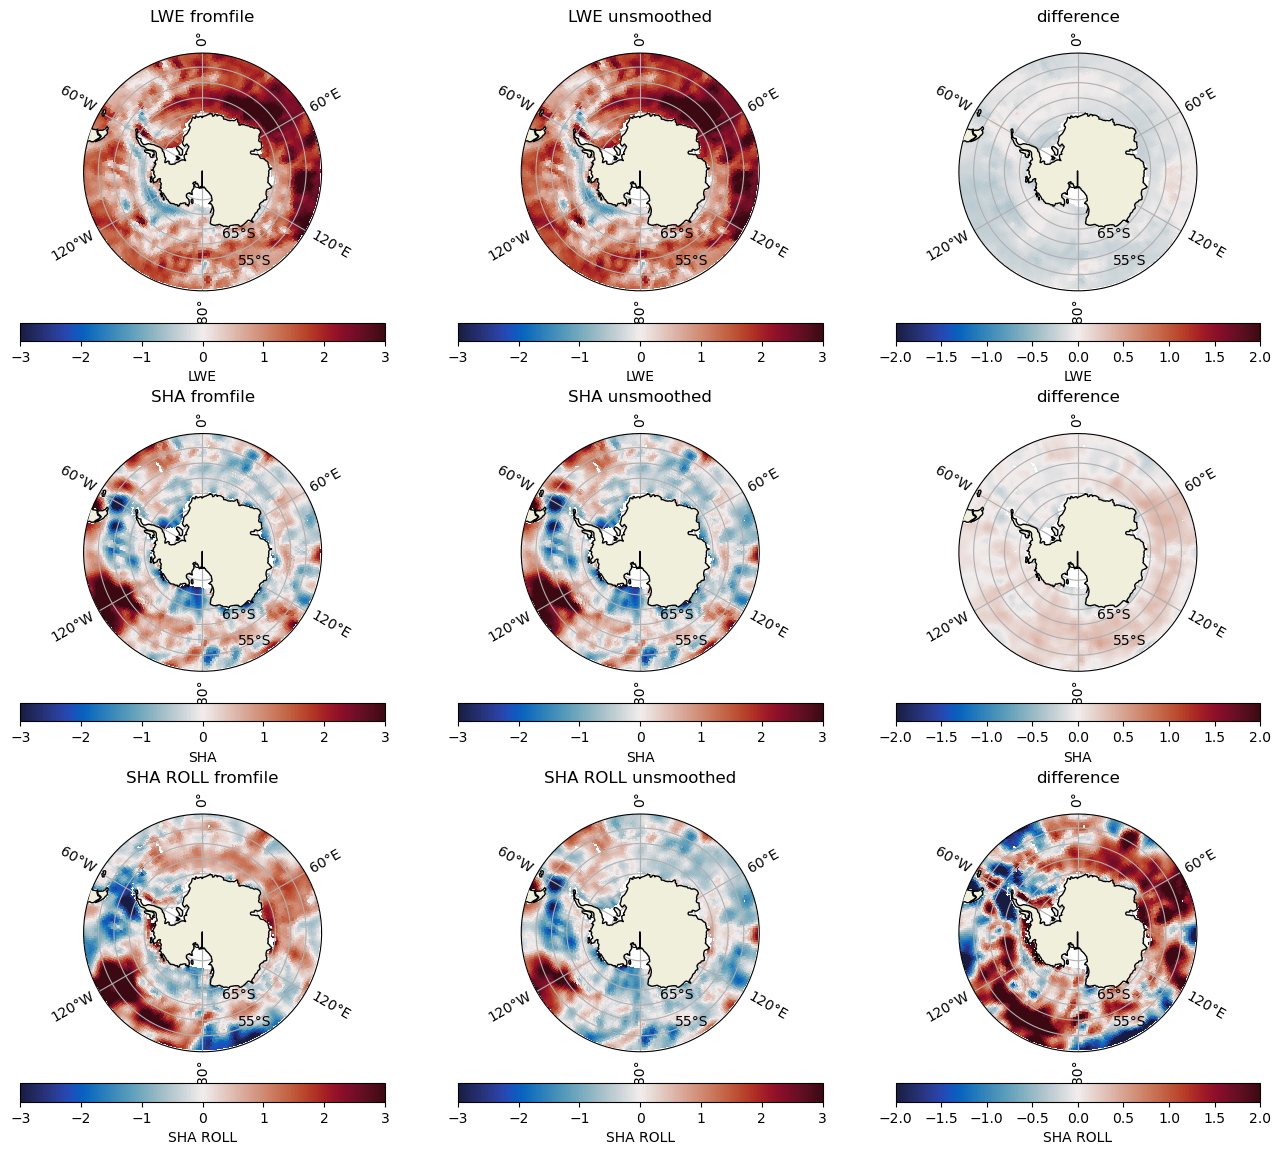

In [50]:
fig,ax = plt.subplots(3,3,figsize=(16,14),subplot_kw={'projection':ccrs.SouthPolarStereo()})

def plot_row(r,df,du,lbl):
    gf_neg = df.where(idx==True,drop=True)
    gu_neg = du.where(idx==True,drop=True)
    pfns.sp(ax[r][0],gf_neg.mean('time'),title=lbl+' fromfile',vmax=3,cmap=cmocean.cm.balance,cbar=lbl)
    pfns.sp(ax[r][1],gu_neg.mean('time'),title=lbl+' unsmoothed',vmax=3, cmap = cmocean.cm.balance,cbar=lbl)
    pfns.sp(ax[r][2],gf_neg.mean('time') - gu_neg.mean('time'),title='difference',vmax=2,cmap=cmocean.cm.balance,cbar=lbl)

plot_row(0,shaf.lwe,sha.lwe,'LWE')
plot_row(1,shaf.sha,sha.sha,'SHA')
plot_row(2,shaf.sha.rolling(time=12,center=True).mean('time'),sha.sha.rolling(time=12,center=True).mean('time'),'SHA ROLL')



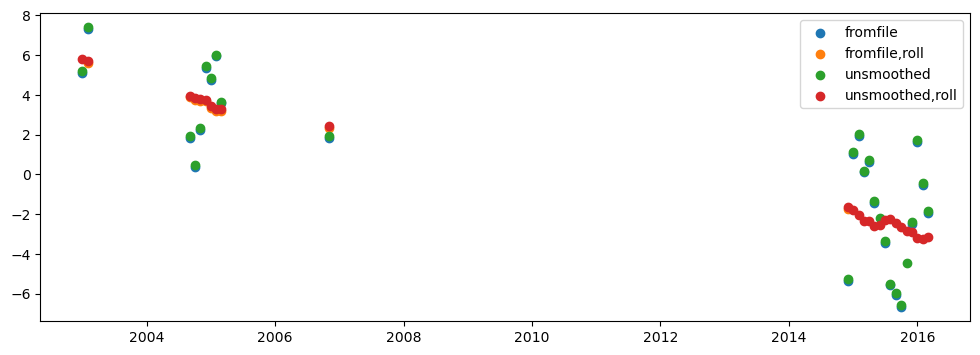

In [69]:
x = -150
y = -56

def prep(da):
    return da.where(idx==True,drop=True).sel(longitude=x,latitude=y,method='nearest')
t = shaf.sha.where(idx==True,drop=True).time

fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(t,prep(shaf.sha),label='fromfile')
ax.scatter(t,prep(shaf.sha.rolling(time=12,center=True).mean('time')),label='fromfile,roll')
ax.scatter(t,prep(sha.sha),label='unsmoothed')
ax.scatter(t,prep(sha.sha.rolling(time=12,center=True).mean('time')),label='unsmoothed,roll')
ax.legend(loc='best')

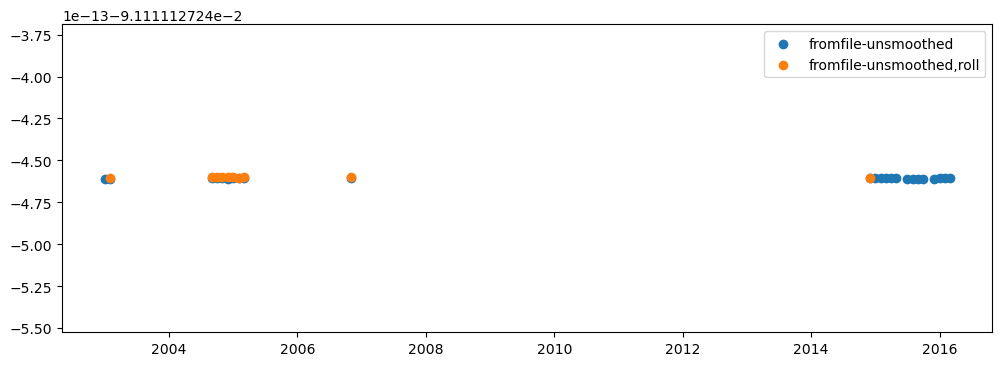

In [70]:
x = -150
y = -56

def prep(da):
    return da.where(idx==True,drop=True).sel(longitude=x,latitude=y,method='nearest')
t = shaf.sha.where(idx==True,drop=True).time

fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(t,prep(shaf.sha)-prep(sha.sha),label='fromfile-unsmoothed')
ax.scatter(t,prep(shaf.sha.rolling(time=12,center=True).mean('time'))-prep(sha.sha.rolling(time=12,center=True).mean('time')),label='fromfile-unsmoothed,roll')
ax.legend(loc='best')

In [76]:
np.mean(prep(shaf.sha.rolling(time=12,center=True).mean('time')))

<xarray.DataArray 'sha' ()> Size: 8B
array(3.09277558)
Coordinates:
    longitude  float64 8B -149.5
    latitude   float64 8B -55.75

In [77]:
np.mean(prep(sha.sha.rolling(time=12,center=True).mean('time')))

<xarray.DataArray 'sha' ()> Size: 8B
array(-0.04217751)
Coordinates:
    longitude  float64 8B -149.5
    latitude   float64 8B -55.75